In [1]:
!pip install gupload

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 61kB 2.8MB/s 
ERROR: earthengine-api 0.1.266 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.7.10 which is incompatible.
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [2]:
!git clone --recursive https://github.com/Microsoft/LightGBM 
!cd LightGBM && mkdir build && cd build
!pip install cmake
!cmake -DUSE_GPU=1 ..
!make -j4
!pip uninstall lightgbm

Cloning into 'LightGBM'...
remote: Enumerating objects: 22211, done.
remote: Counting objects: 100% (757/757), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 22211 (delta 467), reused 604 (delta 408), pack-reused 21454
Receiving objects: 100% (22211/22211), 17.51 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (16178/16178), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused

In [3]:
%cd LightGBM/python-package
!python3 setup.py install --gpu

/content/LightGBM/python-package
running install
INFO:LightGBM:Starting to compile the library.
INFO:LightGBM:Starting to compile with CMake.
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writin

In [4]:
%cd ../../

/content


In [5]:
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
import lightgbm
import gc
import pickle
import sys

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Read Preprocessed data
id_dataset = '1Y_cNEgLNsATfL8BGb-Ovz4cpWqxy72JD'
data = drive.CreateFile({'id':id_dataset})   
data.GetContentFile('df_processed.pkl')

In [8]:
df = pd.read_pickle('df_processed.pkl')

# Train / Validation

In [10]:
X_train = df[df["date_block_num"]<33].drop("target",axis=1)
X_val   = df[df["date_block_num"]==33].drop("target",axis=1)
X_test  = df[df["date_block_num"]==34].drop("target",axis=1)

y_train = df[df["date_block_num"]<33].target
y_val   = df[df["date_block_num"]==33].target

In [11]:
del df
gc.collect();

# LIGHTGBM

In [16]:
lgbm_params = {
    'num_leaves': range(200,300,10),
    'colsample_bylevel': np.linspace(0.7,0.99),
    'feature_fraction' : np.linspace(0.7,0.99),
    'bagging_fraction': np.linspace(0.75,0.99),
    'num_iterations': [1000],
    'learning_rate':[0.005],
    'seed':[42],
    'metric': ["rmse"],
    'early_stopping': [150],
    'device':['gpu']
}

In [17]:
lgbm_randomized_search = {"PARAMS":["a"],"TRAIN_SCORE":[999], "VAL_SCORE":[999]}

n_iter = 11
best_model = []
np.random.seed=42
for i in range(n_iter):
  print(f"Iteration: {i}")
  params = {}
  for x,y in lgbm_params.items():
      #Randomized Search
      params[x] = np.random.choice(y)

  #Train the model
  lgbm = LGBMRegressor(**params, eval_metric="rmse")
  lgbm.fit(X_train,y_train, eval_set = (X_val, y_val), verbose=100)
  train_score = np.sqrt(mean_squared_error(y_train,lgbm.predict(X_train)))
  val_score   = lgbm.best_score_["valid_0"]["rmse"]
  #Best Model
  if val_score < min(lgbm_randomized_search["VAL_SCORE"]):
    best_model = lgbm
  #Append values
  lgbm_randomized_search["PARAMS"].append(params)
  lgbm_randomized_search["TRAIN_SCORE"].append(train_score)
  lgbm_randomized_search["VAL_SCORE"].append(val_score)
  print(f"> Train Score: {train_score}\n> Validation Score: {val_score}")
  print("...............................")
  del lgbm, train_score, val_score
  gc.collect();

lgbm_randomized_search = pd.DataFrame(lgbm_randomized_search).drop(0)

Iteration: 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.7118367346938775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7118367346938775
[LightGBM] [Warning] bagging_fraction is set=0.7989795918367347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7989795918367347
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921654
[200]	valid_0's rmse: 0.85392
[300]	valid_0's rmse: 0.8278
[400]	valid_0's rmse: 0.818018
[500]	valid_0's rmse: 0.813828
[600]	valid_0's rmse: 0.813201
[700]	valid_0's rmse: 0.814052
Early stopping, best iteration is:
[621]	valid_0's rmse: 0.813092
> Train Score: 0.8146163337544371
> Validation Score: 0.8130917868511108
...............................
Iteration: 1

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.7769387755102041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7769387755102041
[LightGBM] [Warning] bagging_fraction is set=0.9557142857142857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557142857142857
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921649
[200]	valid_0's rmse: 0.854201
[300]	valid_0's rmse: 0.828304
[400]	valid_0's rmse: 0.818156
[500]	valid_0's rmse: 0.814946
[600]	valid_0's rmse: 0.813769
[700]	valid_0's rmse: 0.814935
Early stopping, best iteration is:
[603]	valid_0's rmse: 0.813726
> Train Score: 0.8135225939181255
> Validation Score: 0.813725638497431
...............................
Iteration:

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.9308163265306122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308163265306122
[LightGBM] [Warning] bagging_fraction is set=0.9018367346938776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9018367346938776
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921631
[200]	valid_0's rmse: 0.855505
[300]	valid_0's rmse: 0.830458
[400]	valid_0's rmse: 0.821586
[500]	valid_0's rmse: 0.817685
[600]	valid_0's rmse: 0.818551
Early stopping, best iteration is:
[512]	valid_0's rmse: 0.817397
> Train Score: 0.8185679975187661
> Validation Score: 0.8173966883479593
...............................
Iteration: 3


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.9604081632653061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604081632653061
[LightGBM] [Warning] bagging_fraction is set=0.9410204081632653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9410204081632653
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921959
[200]	valid_0's rmse: 0.856538
[300]	valid_0's rmse: 0.832086
[400]	valid_0's rmse: 0.823399
[500]	valid_0's rmse: 0.819041
[600]	valid_0's rmse: 0.819039
Early stopping, best iteration is:
[533]	valid_0's rmse: 0.8188
> Train Score: 0.8156202290821742
> Validation Score: 0.8187996358587597
...............................
Iteration: 4


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.830204081632653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.830204081632653
[LightGBM] [Warning] bagging_fraction is set=0.8675510204081632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8675510204081632
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921429
[200]	valid_0's rmse: 0.854608
[300]	valid_0's rmse: 0.829008
[400]	valid_0's rmse: 0.820054
[500]	valid_0's rmse: 0.816858
[600]	valid_0's rmse: 0.817335
Early stopping, best iteration is:
[501]	valid_0's rmse: 0.816839
> Train Score: 0.8175209538163524
> Validation Score: 0.8168393362863883
...............................
Iteration: 5


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.7414285714285714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414285714285714
[LightGBM] [Warning] bagging_fraction is set=0.9606122448979592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9606122448979592
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.92067
[200]	valid_0's rmse: 0.852874
[300]	valid_0's rmse: 0.826827
[400]	valid_0's rmse: 0.817454
[500]	valid_0's rmse: 0.814252
[600]	valid_0's rmse: 0.813239
[700]	valid_0's rmse: 0.813911
Early stopping, best iteration is:
[627]	valid_0's rmse: 0.813164
> Train Score: 0.8018577169504605
> Validation Score: 0.8131637268201799
...............................
Iteration:

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.9663265306122448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9663265306122448
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.922029
[200]	valid_0's rmse: 0.856687
[300]	valid_0's rmse: 0.831783
[400]	valid_0's rmse: 0.822562
[500]	valid_0's rmse: 0.818052
[600]	valid_0's rmse: 0.81819
Early stopping, best iteration is:
[527]	valid_0's rmse: 0.817719
> Train Score: 0.8210519800755033
> Validation Score: 0.8177194258248119
...............................
Iteration: 7


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.8716326530612245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8716326530612245
[LightGBM] [Warning] bagging_fraction is set=0.8871428571428571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871428571428571
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921478
[200]	valid_0's rmse: 0.85455
[300]	valid_0's rmse: 0.829332
[400]	valid_0's rmse: 0.820386
[500]	valid_0's rmse: 0.817429
[600]	valid_0's rmse: 0.816881
[700]	valid_0's rmse: 0.819224
Early stopping, best iteration is:
[609]	valid_0's rmse: 0.816812
> Train Score: 0.8039600675515531
> Validation Score: 0.8168124019574251
...............................
Iteration:

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.8657142857142857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657142857142857
[LightGBM] [Warning] bagging_fraction is set=0.8038775510204081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8038775510204081
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921161
[200]	valid_0's rmse: 0.853994
[300]	valid_0's rmse: 0.828954
[400]	valid_0's rmse: 0.820238
[500]	valid_0's rmse: 0.817095
[600]	valid_0's rmse: 0.816497
[700]	valid_0's rmse: 0.818464
Early stopping, best iteration is:
[598]	valid_0's rmse: 0.816397
> Train Score: 0.8099220605882687
> Validation Score: 0.8163973975676091
...............................
Iteration

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.806530612244898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.806530612244898
[LightGBM] [Warning] bagging_fraction is set=0.980204081632653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.980204081632653
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921114
[200]	valid_0's rmse: 0.854083
[300]	valid_0's rmse: 0.828827
[400]	valid_0's rmse: 0.818787
[500]	valid_0's rmse: 0.81551
[600]	valid_0's rmse: 0.815473
Early stopping, best iteration is:
[547]	valid_0's rmse: 0.815186
> Train Score: 0.8112892644048874
> Validation Score: 0.8151863395263055
...............................
Iteration: 10


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:152: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:157: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] feature_fraction is set=0.7355102040816326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7355102040816326
[LightGBM] [Warning] bagging_fraction is set=0.8920408163265305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8920408163265305
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping=150 will be ignored. Current value: early_stopping_round=150
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.921028
[200]	valid_0's rmse: 0.853586
[300]	valid_0's rmse: 0.828062
[400]	valid_0's rmse: 0.818849
[500]	valid_0's rmse: 0.816023
[600]	valid_0's rmse: 0.814862
[700]	valid_0's rmse: 0.815092
Early stopping, best iteration is:
[627]	valid_0's rmse: 0.814536
> Train Score: 0.8047487067121719
> Validation Score: 0.8145355792433099
...............................


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


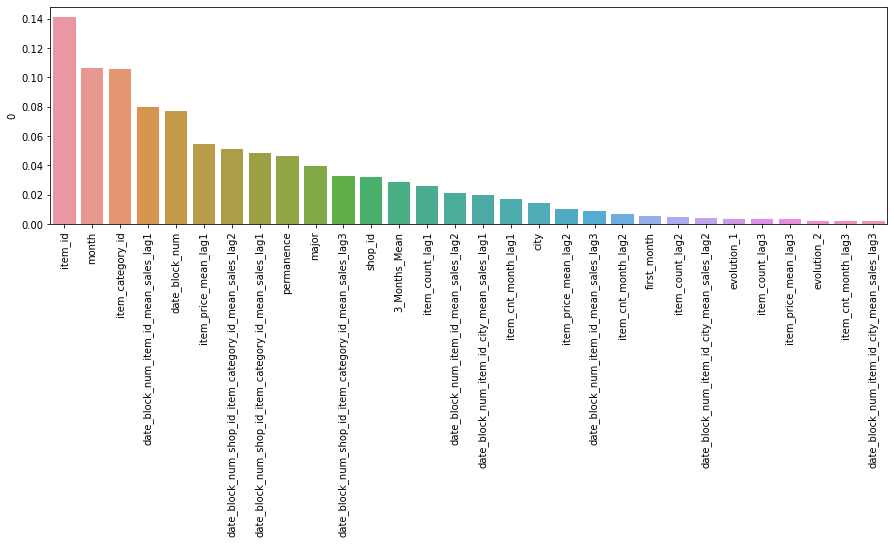

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
feat_importance = pd.DataFrame(best_model.feature_importances_/best_model.feature_importances_.sum()\
                                        , index=X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(15,4))
sns.barplot(feat_importance.index, feat_importance[0])
plt.xticks(rotation=90);

In [19]:
pickle.dump(best_model,open("lgbm.pkl",'wb'))
!gupload --to '1fUe3r9HhiN576xtpLTxp7LBwIbK_mpqp' lgbm.pkl

Uploading file: lgbm.pkl


In [20]:
lgbm_randomized_search.to_csv("lgbm_randomized_search.csv")
!gupload --to '1fUe3r9HhiN576xtpLTxp7LBwIbK_mpqp' lgbm_randomized_search.csv

Uploading file: lgbm_randomized_search.csv


LB score: 0.90093